# **Initial EDA**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.impute import KNNImputer

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/ISC Case study/Data/fraud_detection_dataset.csv')

In [ ]:
df.head()

In [ ]:
df.columns.tolist()

In [ ]:
df.info()

In [ ]:
df.describe()

In [ ]:
df.duplicated().sum()

***Data Quality Issues***


*   *fico_score, avg_balance_last_12months, number_of_delinquent_accounts* and *unusual_submission_pattern* have missing values
*   Incorrect data type : *unusual_submission_pattern* is a bool variable but stored as an object
*   Date columns need conversion to datetime format : *Account_open_date, Earliest_credit_account, Recent_trade_activity*
*   There may be potential outliers in *max_balance, fico_score*, and *debt_to_income_ratio* because of high ranges




# **Data Cleaning**

In [ ]:
#Convert date columns to datetime format
date_columns = ['account_open_date', 'earliest_credit_account', 'recent_trade_activity']
for col in date_columns:
    df[col] = pd.to_datetime(df[col], errors='coerce')

In [ ]:
df.info()

In [ ]:
df.isnull().sum()

**Handling missing values**

In [ ]:
p_1 = (210/7000)*100
p_2 = (350/7000)*100
p_3 = (700/7000)*100
p_4 = (910/7000)*100

p_1,p_2,p_3,p_4

In this dataset, there are 3%, 5%, 10% and 13% of records are missing in fico_sccore, avg_balance_last_12months, number_of_delinquent_accounts and unusual_submission_pattern respectively.

therefore removing rows with missing values would lead to significant data loss.since columns such as fico_score, are highly relevant to financial risk analysis.

**Handling Missing values using KNN**

In [ ]:
features_for_imputation = ['avg_balance_last_12months', 'number_of_delinquent_accounts', 'fico_score','unusual_submission_pattern']
df_imputation = df[features_for_imputation].copy()
df_imputation

In [ ]:
imputer = KNNImputer(n_neighbors=10)

# Fit and transform the data
df_imputed = imputer.fit_transform(df_imputation)

# Convert back to DataFrame
df_imputed = pd.DataFrame(df_imputed, columns=features_for_imputation)
df_imputed['number_of_delinquent_accounts'] = df_imputed['number_of_delinquent_accounts'].round().astype(int)
df_imputed['unusual_submission_pattern'] = df_imputed['unusual_submission_pattern'].apply(lambda x: True if x >= 0.5 else False)


In [ ]:
df[features_for_imputation] = df_imputed[features_for_imputation]

In [ ]:
df.isnull().sum()

**Handling outliers**

In [ ]:
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns

In [ ]:
plt.figure(figsize=(20, 10))

sns.boxplot(data=df[numerical_columns], orient='h')

plt.title('Boxplot of Numerical Columns - Outlier Detection', fontsize=16)
plt.xlabel('Values', fontsize=12)
plt.ylabel('Columns', fontsize=12)
plt.tight_layout()

plt.show()

In [ ]:
def detect_outliers(df, columns):
    outliers_summary = {}
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - (1.5 * IQR)
        upper_bound = Q3 + (1.5 * IQR)

        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        outliers_summary[col] = {
            'total_outliers': len(outliers),
            'percent_outliers': (len(outliers) / len(df)) * 100,
            'lower_bound': lower_bound,
            'upper_bound': upper_bound
        }

    return outliers_summary

# Print outliers summary
outliers_info = detect_outliers(df, numerical_columns)
for col, info in outliers_info.items():
    print(f"\nColumn: {col}")
    print(f"Total Outliers: {info['total_outliers']}")
    print(f"Percent of Outliers: {info['percent_outliers']:.2f}%")
    print(f"Lower Bound: {info['lower_bound']}")
    print(f"Upper Bound: {info['upper_bound']}")

**Outlier Analysis**

In [ ]:
outliers = {}

for col in df[numerical_columns]: # Include only numerical columns

    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter the outliers
    outliers[col] = df[(df[col] < lower_bound) | (df[col] > upper_bound)]

# Combine all outliers into one DataFrame
all_outliers = pd.concat(outliers.values()).drop_duplicates()

charge_off_analysis = all_outliers['charge_off_status'].value_counts()

print("Charge-off counts among outliers:")
print(charge_off_analysis)

Among all outliers, 1271 cases are charge off cases.

In [ ]:
fico_outliers = outliers['fico_score']
fico_charge_off_analysis = fico_outliers['charge_off_status'].value_counts()

fico_charge_off_analysis

In [ ]:
dir_outliers = outliers['debt_to_income_ratio']

dir_analysis = dir_outliers['charge_off_status'].value_counts()

dir_analysis

In [ ]:
mb_outliers = outliers['max_balance']

mb_analysis = mb_outliers['charge_off_status'].value_counts()

mb_analysis

In [ ]:
ds_outliers = outliers['delinquency_status']

ds_analysis = ds_outliers['charge_off_status'].value_counts()

ds_analysis

In [ ]:
income_level_outliers = outliers['income_level']

income_level_analysis = income_level_outliers['charge_off_status'].value_counts()

income_level_analysis

In [ ]:
nca_outliers = outliers['number_of_credit_applications']

nca_analysis = nca_outliers['charge_off_status'].value_counts()

nca_analysis

Outliers can be seen in features like *income_level, fico_score, delinquency_status, number_of_credit_applications, debt_to_income_ratio and max_balance*

Even though there are high proportion of outliers present in delinquency_status,number_of_credit_applications and debt_to_income_ratio, we are not gonna handle all of those. because they represent essential risk signals in the context of financial fraud detection.

But we handled fico_score, debt_to_income_ratio, and max_balance, Because these variables are continuous, quantitative financial metrics that are likely to contain anomalies caused by Data entry errors or Unusually extreme financial circumstances. and those outliers not represent any charge off status.

In [ ]:
#handle outliers using IQR
def handle_outliers_iqr(column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    #Capping outliers to the lower and upper bounds
    df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)
    return (lower_bound, upper_bound)

#handle outliers for the selected columns
outlier_bounds = {}
columns_to_check = ['fico_score', 'debt_to_income_ratio', 'max_balance']
for col in columns_to_check:
    outlier_bounds[col] = handle_outliers_iqr(col)

outlier_bounds


In [ ]:
df[df['fico_score'] < 300].shape[0],
df[df['fico_score'] > 850].shape[0]

In [ ]:
df['fico_score'] = df['fico_score'].apply(lambda x: max(300, min(850, x)))


In [ ]:
df.describe()

# **Feature Engineering**

Adding two new columns that are derived from available data


*   account_age_days : Account age in days
*   credit_history_length : length of time between the earliest credit account and the most recent credit activity



In [ ]:
df['account_age_days'] = (pd.Timestamp.now() - df['account_open_date']).dt.days


In [ ]:
df['credit_history_length'] = (df['recent_trade_activity'] - df['earliest_credit_account']).dt.days


In [ ]:
df.head()

# **EDA**

In [ ]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='charge_off_status', data=df)
plt.title('Distribution of Charge-Off Status')
plt.xlabel('Charge-Off Status')
plt.ylabel('Count')

total = len(df)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()/2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center')

plt.show()

The proportions of 73.9% False and 26.1% True in the charge_off_status column. A 26.1% minority class is not severely imbalanced. We balance dataset by resmpling


**Numerical Data**

In [ ]:
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns
numerical_columns

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# List of numerical columns
numerical_columns = numerical_columns

# Number of rows and columns for the subplot grid
n_cols = 3  # Number of columns in the grid
n_rows = (len(numerical_columns) + n_cols - 1) // n_cols  # Calculate the required number of rows

# Create a grid of subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 6, n_rows * 4))

# Flatten the axes array in case the grid is more than one row
axes = axes.flatten()

# Loop through numerical columns and plot distributions
for i, col in enumerate(numerical_columns):
    sns.histplot(df[col], kde=True, bins=30, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

# Hide axes for empty subplots if there are fewer columns than slots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()


**Distribution Analysis**


*   *fico_score*: Approximately symmetric, though with some concentration around the mean.
*   *debt_to_income_ratio*: Skewed, indicating higher concentrations around specific values.
*   *max_balance*: Slightly skewed with outlier capping applied.
*   *avg_balance_last_12months*: Moderately symmetric but with variability, showing patterns in financial behavior.






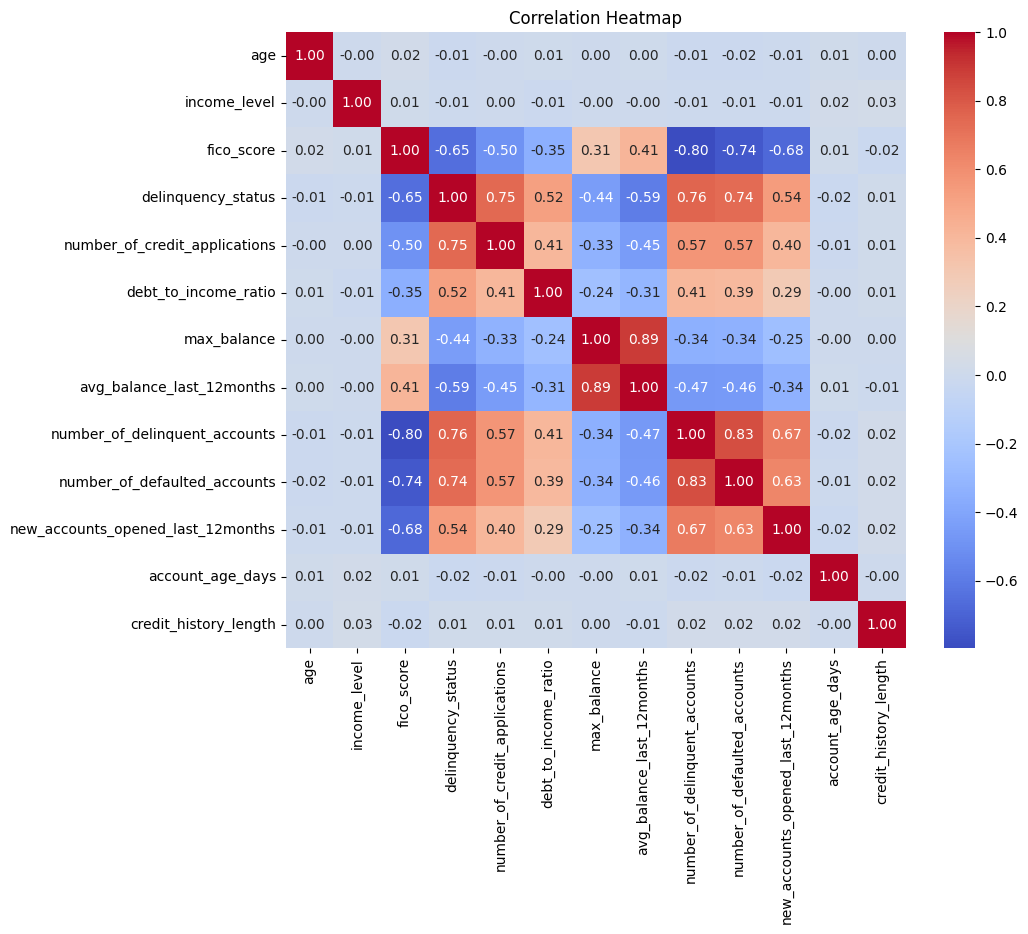

In [ ]:
#Correlation heatmap for numerical features
plt.figure(figsize=(10, 8))
correlation_matrix = df[numerical_columns].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()



*   Variables like max_balance and avg_balance_last_12months show expected positive correlations, indicating financial stability patterns



**Categorical Data**

In [ ]:
categorical_columns = df.select_dtypes(include=['bool', 'object']).columns
categorical_columns = list(categorical_columns)


In [ ]:
categorical_columns

['location',
 'occupation',
 'charge_off_status',
 'payment_methods_high_risk',
 'multiple_applications_short_time_period',
 'unusual_submission_pattern',
 'applications_submitted_during_odd_hours',
 'watchlist_blacklist_flag',
 'public_records_flag']

In [ ]:
categorical_summary = {}
for col in categorical_columns:
    categorical_summary[col] = df[col].value_counts()

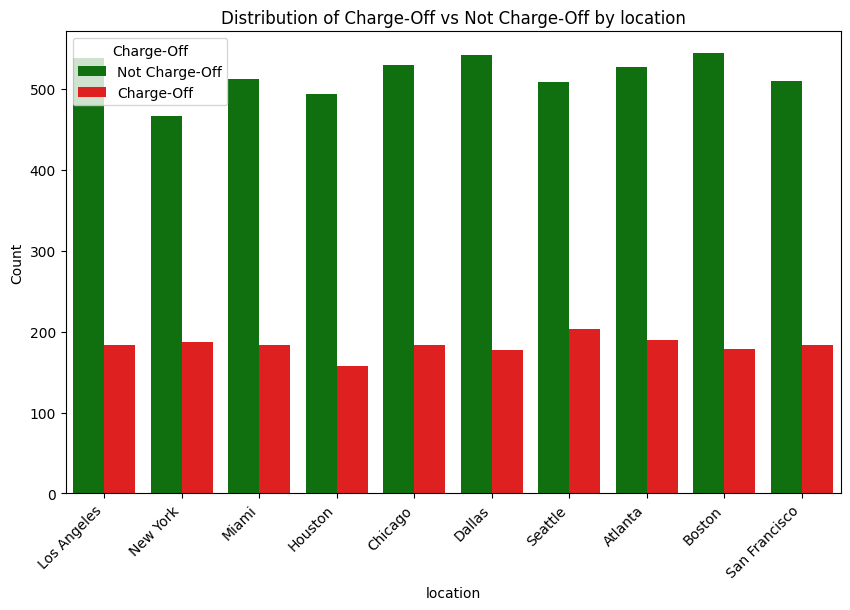

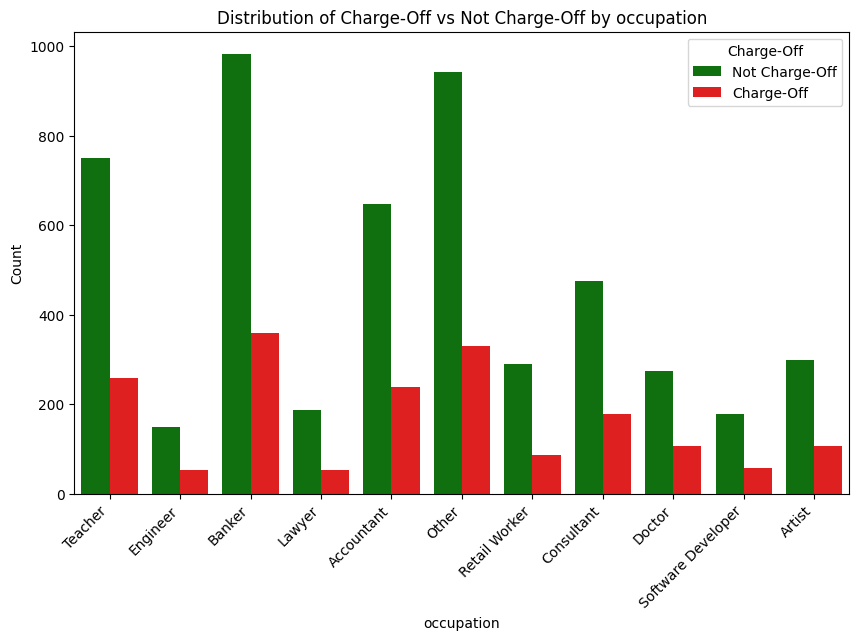

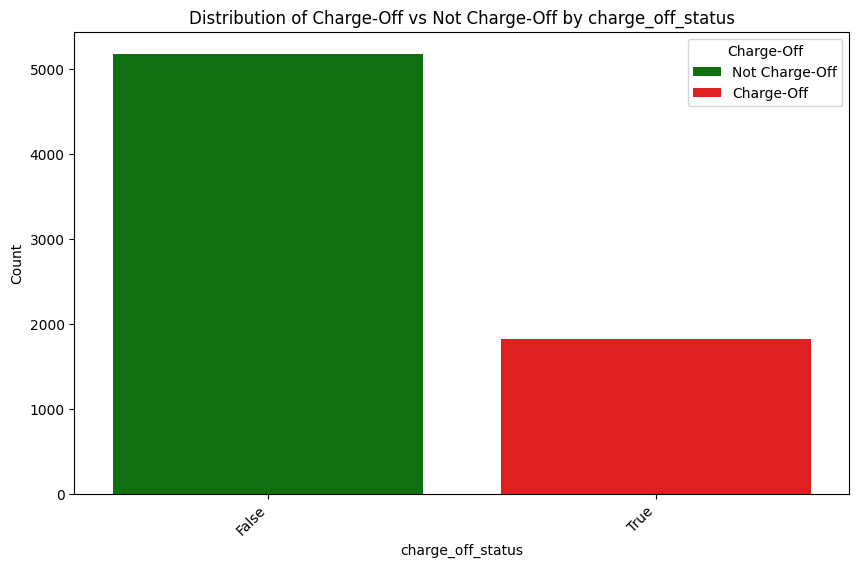

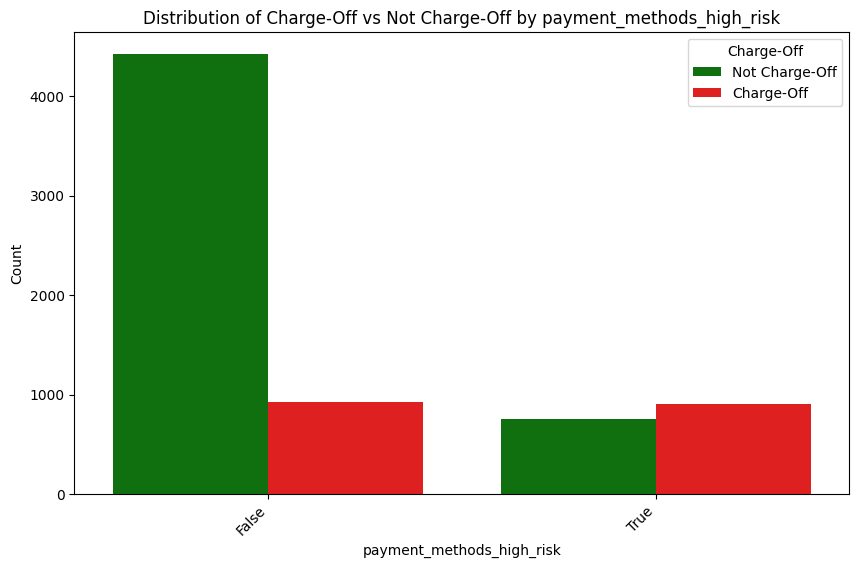

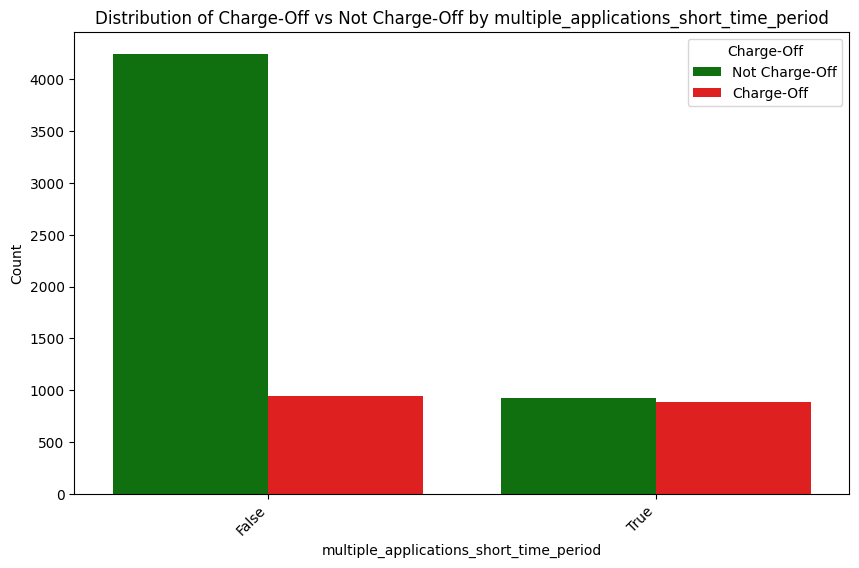

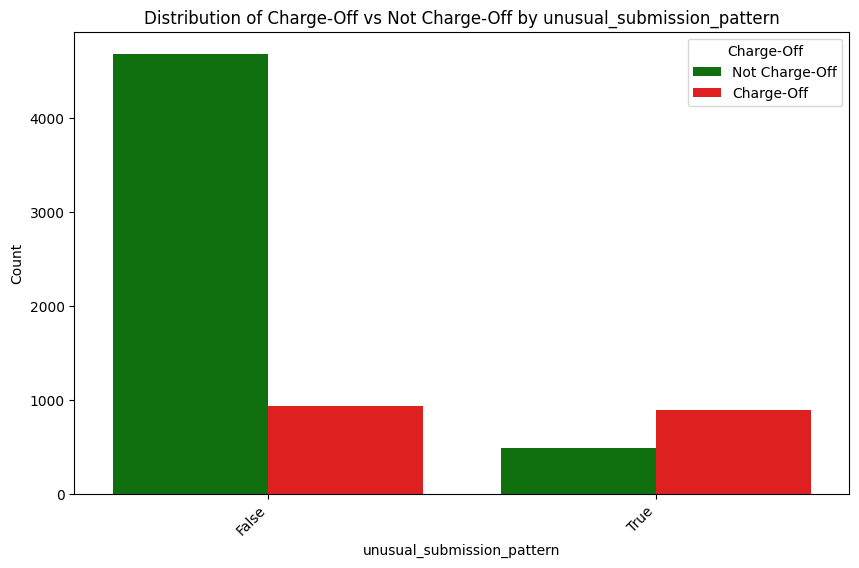

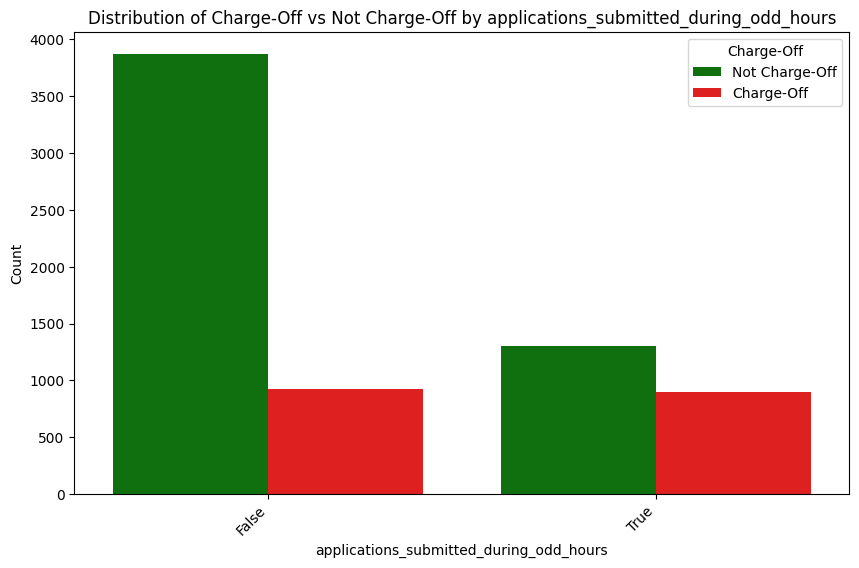

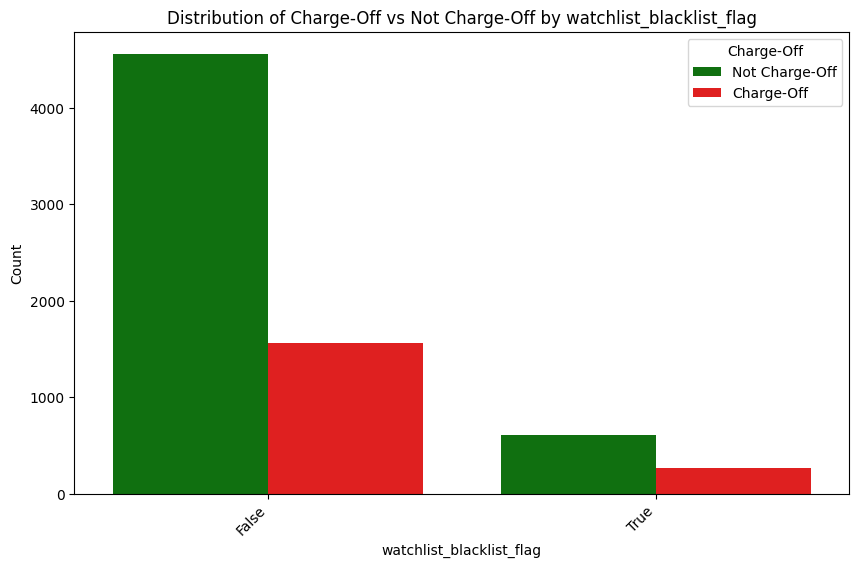

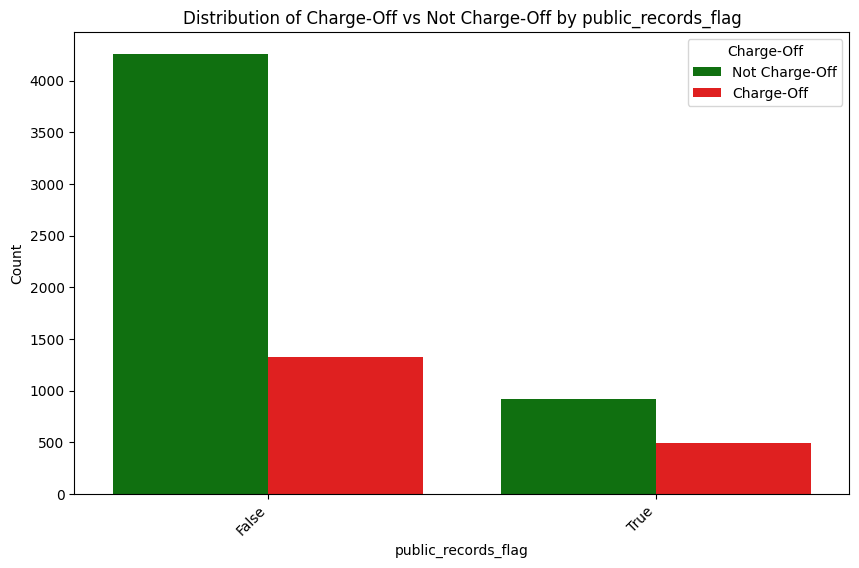

In [ ]:
for col, summary in categorical_summary.items():
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x=col, hue='charge_off_status', palette=['green', 'red'])
    plt.title(f'Distribution of Charge-Off vs Not Charge-Off by {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Charge-Off', labels=['Not Charge-Off', 'Charge-Off'])
    plt.show()

**Summary of Key Categorical Features**

*   *Location:* The dataset contains individuals from 10 major cities. The most common cities are Los Angeles and Boston.
*   *Occupation:* The top professions are "Banker", while "Engineer" has the least representation.
*   *payment_methods_high_risk:* 1,657 entries flagged as high-risk.
*   *applications_submitted_during_odd_hours:* 2,200 entries submitted during odd hours
*   *watchlist_blacklist_flag:* 880 entries are flagged on watchlists
*   *public_records_flag:* 1,413 entries have public record issues.



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# List of numerical features to plot against charge_off_status
numerical_features = ['fico_score', 'debt_to_income_ratio']  # Add more numerical features as needed

# Number of rows and columns for the subplot grid
n_cols = 2  # Number of columns in the grid (since we have 2 features)
n_rows = (len(numerical_features) + n_cols - 1) // n_cols  # Calculate the required number of rows

# Create a grid of subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 6, n_rows * 6))

# Flatten the axes array in case the grid is more than one row
axes = axes.flatten()

# Loop through numerical features and plot boxplots
for i, feature in enumerate(numerical_features):
    sns.boxplot(x='charge_off_status', y=feature, data=df, ax=axes[i])
    axes[i].set_title(f'{feature} by Charge-Off Status')
    axes[i].set_xlabel('Charge-Off Status')
    axes[i].set_ylabel(feature)

# Hide axes for empty subplots if there are fewer features than slots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()


In [ ]:
#Visualize `charge_off_status` against numerical features
plt.figure(figsize=(8, 6))
sns.boxplot(x='charge_off_status', y='fico_score', data=df)
plt.title('FICO Score Distribution by Charge-Off Status')
plt.xlabel('Charge-Off Status')
plt.ylabel('FICO Score')
plt.show()

plt.figure(figsize=(8, 6))
sns.boxplot(x='charge_off_status', y='debt_to_income_ratio', data=df)
plt.title('Debt-to-Income Ratio by Charge-Off Status')
plt.xlabel('Charge-Off Status')
plt.ylabel('Debt-to-Income Ratio')
plt.show()




*   *FICO Score:* Lower FICO scores are associated with charge-offs, highlighting a potential risk relationship.
*   *Debt-to-Income Ratio:* Higher debt-to-income ratios are correlated with charge-offs, indicating financial instability




In [ ]:
#Analyze `charge_off_status` by `occupation` and `location`
occupation_risk = df.groupby('occupation')['charge_off_status'].mean().sort_values(ascending=False)
location_risk = df.groupby('location')['charge_off_status'].mean().sort_values(ascending=False)


In [ ]:
plt.figure(figsize=(10, 6))
occupation_risk.plot(kind='bar', color='skyblue')
plt.title('Charge-Off Rate by Occupation')
plt.xlabel('Occupation')
plt.ylabel('Charge-Off Rate')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 6))
location_risk.plot(kind='bar', color='orange')
plt.title('Charge-Off Rate by Location')
plt.xlabel('Location')
plt.ylabel('Charge-Off Rate')
plt.xticks(rotation=45)
plt.show()

In [ ]:
occupation_risk, location_risk

**Charge-Off Rate by Occupation**


*   Doctors (28.1%) have the highest charge-off rate, followed by Consultants (27.2%) and Accountants (26.9%)
*   Lawyers (22.2%) and Retail Workers (23.1%) show lower charge-off rates



**Charge-Off Rate by Location**


*   New York (28.6%) and Seattle (28.5%) show the highest charge-off rates, indicating higher risk in these locations
*   Houston (24.1%) and Dallas (24.6%) have lower charge-off rates



In [ ]:
#Analyze combined risk factors - FICO Score by Occupation
fico_by_occupation = df.groupby('occupation')['fico_score'].mean().sort_values()

# Step 2: Visualize average FICO score by occupation
plt.figure(figsize=(10, 6))
fico_by_occupation.plot(kind='bar', color='lightgreen')
plt.title('Average FICO Score by Occupation')
plt.xlabel('Occupation')
plt.ylabel('Average  FICO Score')
plt.xticks(rotation=45)
plt.show()


**FICO Score by Occupation**


*   Lower average FICO scores are observed among high-risk occupations such as Consultants.
*   Higher average FICO scores are associated with Lawyers and Software Developers, indicating better financial stability



In [ ]:
#Analyze binary risk flags and their correlation with financial metrics
binary_flags = ['charge_off_status', 'payment_methods_high_risk',
                'applications_submitted_during_odd_hours', 'watchlist_blacklist_flag', 'public_records_flag']

binary_correlations = df[binary_flags + ['fico_score', 'debt_to_income_ratio', 'max_balance','avg_balance_last_12months','number_of_delinquent_accounts','unusual_submission_pattern']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(binary_correlations, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Between Binary Flags and Financial Metrics')
plt.show()

**Correlation Heatmap inslights - charge_off_status**


*   Negatively correlated with fico_score (-0.42): Lower FICO scores strongly indicate higher charge-off risk
*   Positively correlated with debt_to_income_ratio (0.33): Higher debt-to-income ratios are associated with charge-offs
*   positive correlation with payment_methods_high_risk (0.36)
*   Negatively correlated with avg_balance_last_12months (-0.38)
*   Positively correlated with number_of_delinquent_accounts (0.49)
*   Positively correlated with unusual_submission_pattern (0.43)



# **Data Preprocessing**

In [ ]:
df.info()

In [ ]:
le = LabelEncoder()
categorical_cols = ['location', 'occupation']

for col in categorical_cols:
    df[col + '_encoded'] = le.fit_transform(df[col])


In [ ]:
df = df.drop(['account_open_date', 'earliest_credit_account', 'recent_trade_activity','location', 'occupation'], axis=1)

In [ ]:
bool_columns = df.select_dtypes(include=['bool']).columns
bool_columns

In [ ]:
df[bool_columns] = df[bool_columns].astype(int)

### **Resampling  - Balance Dataset**

In [ ]:
df_2 = df.copy(deep = True)

In [ ]:
class_distribution = df_2['charge_off_status'].value_counts(normalize=True)
class_distribution

In [ ]:
# with df_2
# Separate features and target variable
X = df_2.drop(columns=['charge_off_status'])
y = df_2['charge_off_status']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Apply SMOTE to balance the classes in the training set
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

df_balanced = pd.concat([X_train_balanced, y_train_balanced], axis=1)
df_balanced.head()


In [ ]:
df_balanced.describe()

In [ ]:
df_balanced['charge_off_status'].value_counts(normalize=True)

In [ ]:
df_balanced.to_csv('pre_processed_dataset_balanced.csv', index=False)